In [1]:
#| hide
# skip
! [ -e /content ] && pip install -Uqq model_inspector nbdev
# For colab. Restart the runtime after running this cell!

In [2]:
#| default_exp get_inspector

# Get an Inspector

> Get an appropriate inspector for your model

In [3]:
#| export
import pandas as pd
from model_inspector.inspect.any_model import *
from model_inspector.inspect.classifier import *
from model_inspector.inspect.linear_model import *
from model_inspector.inspect.regressor import *
from model_inspector.inspect.searchcv_estimator import *
from model_inspector.inspect.tree import *
from sklearn.base import BaseEstimator
from sklearn.linear_model._base import (
    LinearClassifierMixin,
    LinearModel,
    RegressorMixin,
)
from sklearn.model_selection._search import BaseSearchCV
from sklearn.tree import BaseDecisionTree
from sklearn.utils.multiclass import type_of_target

In [4]:
#| export
def get_inspector(model: BaseEstimator, X: pd.DataFrame, y: pd.Series) -> _Inspector:
    """Get an appropriate inspector for your model and data

    Parameters:
    - `model`: Fitted sklearn model
    - `X`: Matrix with the same features `model` was trained on
    - `y`: Series with same length as `X` and same meaning as target
    values `model` was trained on
    """
    if isinstance(model, LinearModel):
        return _LinRegInspector(model, X, y)
    elif isinstance(model, LinearClassifierMixin):
        if type_of_target(y) == "binary":
            return _LinBinInspector(model, X, y)
        elif type_of_target(y) == "multiclass":
            return _LinMultiInspector(model, X, y)
    elif isinstance(model, BaseDecisionTree):
        # `type_of_target` can't reliably distinguish between continuous
        # and multiclass
        if isinstance(model, RegressorMixin):
            return _TreeRegInspector(model, X, y)
        elif type_of_target(y) == "binary":
            return _TreeBinInspector(model, X, y)
        elif type_of_target(y) == "multiclass":
            return _TreeMultiInspector(model, X, y)
    elif isinstance(model, BaseSearchCV):
        return _SearchCVInspector(model, X, y)
    # `type_of_target` can't reliably distinguish between continuous and
    # multiclass
    if isinstance(model, RegressorMixin):
        return _RegInspector(model, X, y)
    elif type_of_target(y) == "binary":
        return _BinInspector(model, X, y)
    elif type_of_target(y) == "multiclass":
        return _MultiInspector(model, X, y)
    else:
        return _Inspector(model, X, y)

In [5]:
#| hide
import sklearn.datasets
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

X, y = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)
assert isinstance(get_inspector(LinearRegression().fit(X, y), X, y), _LinRegInspector)
assert isinstance(
    get_inspector(DecisionTreeRegressor().fit(X, y), X, y), _TreeRegInspector
)
assert isinstance(get_inspector(SVR().fit(X, y), X, y), _RegInspector)
assert isinstance(
    get_inspector(GridSearchCV(LinearRegression(), {}).fit(X, y), X, y),
    _SearchCVInspector,
)


X, y = sklearn.datasets.load_breast_cancer(return_X_y=True, as_frame=True)
assert isinstance(
    get_inspector(LogisticRegression(max_iter=10_000).fit(X, y), X, y), _LinBinInspector
)
assert isinstance(
    get_inspector(DecisionTreeClassifier().fit(X, y), X, y), _TreeBinInspector
)
assert isinstance(get_inspector(SVC().fit(X, y), X, y), _BinInspector)

X, y = sklearn.datasets.load_iris(return_X_y=True, as_frame=True)
assert isinstance(
    get_inspector(LogisticRegression(max_iter=10_000).fit(X, y), X, y),
    _LinMultiInspector,
)
assert isinstance(
    get_inspector(DecisionTreeClassifier().fit(X, y), X, y), _TreeMultiInspector
)
assert isinstance(get_inspector(SVC().fit(X, y), X, y), _MultiInspector)

Example:

In [24]:
import sklearn.datasets
from sklearn.tree import DecisionTreeRegressor
from model_inspector import get_inspector

X, y = sklearn.datasets.load_diabetes(return_X_y=True, as_frame=True)

inspector = get_inspector(model=DecisionTreeRegressor().fit(X, y), X=X, y=y)

In [25]:
inspector

model_inspector.inspect.tree._TreeRegInspector(model=DecisionTreeRegressor())

In [26]:
inspector.methods

['permutation_importance',
 'plot_dependence',
 'plot_feature_clusters',
 'plot_permutation_importance',
 'plot_pred_vs_act',
 'plot_residuals',
 'plot_tree',
 'show_correlation']

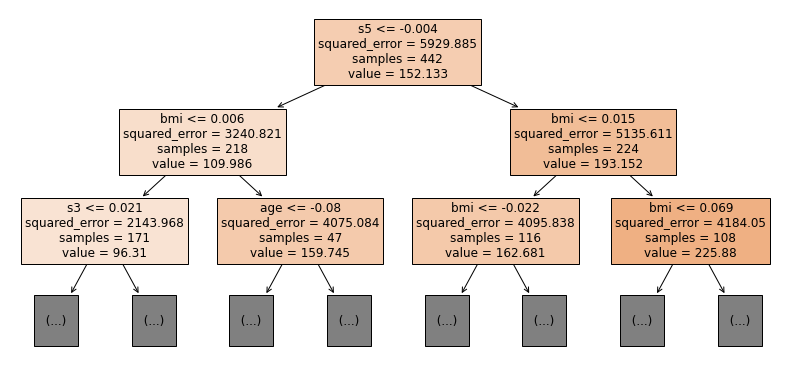

In [28]:
ax = inspector.plot_tree(max_depth=2)